In [1]:
!pip install torch torchvision transformers pillow

In [2]:
# 구글 드라이브 연동 (Google Colab에서만 사용 가능)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive is mounted.")
except ModuleNotFoundError:
    print("google.colab 모듈이 없어 Google Drive를 연동할 수 없습니다. 이 코드는 Colab 환경에서만 동작합니다.")

Mounted at /content/drive
Google Drive is mounted.


/content/drive/MyDrive/Colab Notebooks/SKN19/alpinist_frame00000.jpg


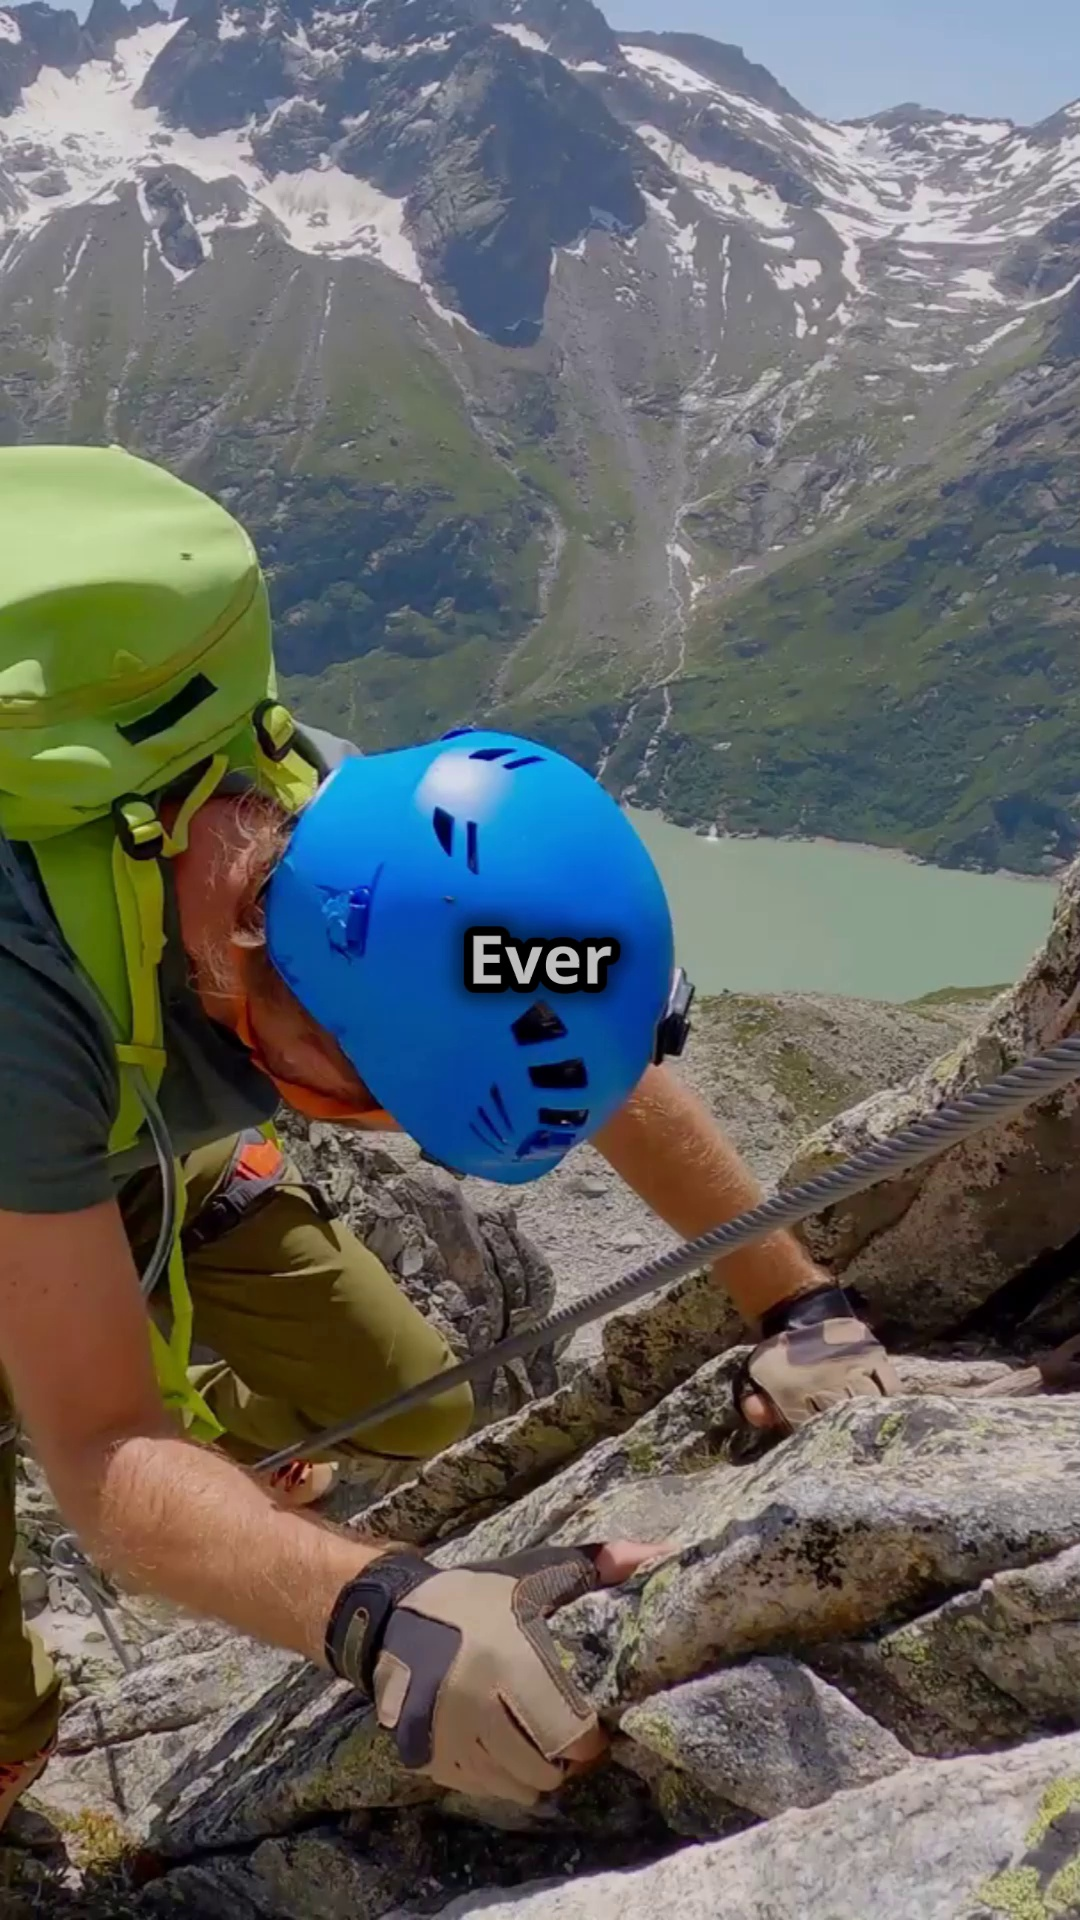

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/SKN19'
relative_image_path = 'alpinist_frame00000.jpg'
image_path = os.path.join(BASE_PATH, relative_image_path)
print(image_path)
image = Image.open(image_path).convert('RGB')

# PIL.Image 출력
display(image)

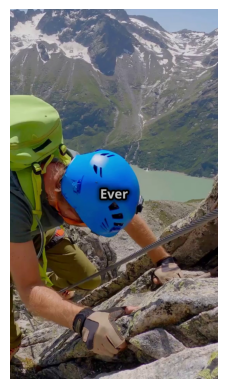

In [5]:
# matplotlib 출력
plt.imshow(image)
plt.axis('off')
plt.show()

### 이미지/텍스트 전처리 및 유사도 비교

- CLIPImageProcessor
- CLIPTokenizer


In [7]:
!pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.5 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=ef0e292b0d34db60057edf4a67b82c862748a2d6500edc0bad295b0581c58149
  Stored in directory: /root/.cache/pip/wheels/ab/49/bc/c2342e8e14878210ba4825cf314a53f2570f6fb18b91fce3cf
Successfully built openai-clip


```python
# 이전 수업에서 진행했던 내용
# model 활용
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, processor = clip.load("ViT-B/32", device=device)

# 이미지 전처리 및 캡션 옵션 생성
from PIL import Image

image = processor(Image.open("./test.jpg")).unsqueeze(0).to(device)
caption_options = [
    "a dog on the grass",
    "a cat on the grass",
    "a pug sitting",
    "a cat on the table"
]

captions = clip.tokenize(caption_options).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(captions)

    logits_per_image, _ = model(image, captions)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print(image_features)
print(text_features)
print("CLIP이 뽑은 Best Caption: ", caption_options[probs.argmax()])
```

In [14]:
# CLIP 클래스 로드
# - CLIPProcessr (CLIPImageProcessor, CLIPTokenizer)
# - CLIPModel
import torch
import clip
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = 'openai/clip-vit-base-patch32'

model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

In [15]:
texts = [
    "A person is climbing a snowy mountain.",
    "A soccer player is kicking the ball.",
    "A cat sitting on the chair.",
    "A landscape with a river and forest."
]

In [17]:
# 전처리(이미지/텍스트) - Processor 사용
inputs = processor(
    images=image,
    text=texts,
    return_tensors='pt',
    padding=True # 길이값 지정 없는 경우, 주어진 text 최대길이에 맞춰 처리
    )

In [18]:
print(inputs['pixel_values'].shape)
print(inputs)

torch.Size([1, 3, 224, 224])
{'pixel_values': tensor([[[[-0.4200, -0.3762, -0.3324,  ..., -0.6536, -0.4054, -0.2594],
          [-0.3470, -0.3616, -0.3616,  ..., -0.2886, -0.2448, -0.4200],
          [-0.3616, -0.3762, -0.3616,  ..., -0.2740, -0.5806, -0.6974],
          ...,
          [-1.2375, -1.3543, -1.1061,  ...,  0.6603,  0.7333,  0.7917],
          [-1.1791, -1.2813, -1.1353,  ...,  0.5727,  0.5873,  0.5873],
          [-1.1645, -1.2375, -1.1207,  ...,  0.5289,  0.5727,  0.4851]],

         [[-0.2813, -0.2363, -0.1913,  ..., -0.5515, -0.3264, -0.1613],
          [-0.1913, -0.2063, -0.2063,  ..., -0.1613, -0.1313, -0.3114],
          [-0.2063, -0.2213, -0.2063,  ..., -0.1763, -0.4764, -0.5815],
          ...,
          [-1.3019, -1.4369, -1.1818,  ...,  0.6041,  0.6942,  0.7542],
          [-1.2718, -1.3769, -1.2418,  ...,  0.5291,  0.5441,  0.5591],
          [-1.2869, -1.3469, -1.2418,  ...,  0.5141,  0.5741,  0.4841]],

         [[ 0.0698,  0.0982,  0.1124,  ..., -0.2004,  0.

In [24]:
# 모델 임베딩 & 유사도 비교
import torch

with torch.no_grad():
    outputs = model(**inputs)
    print(outputs.logits_per_image) # (1, texts 개수)
    probs = outputs.logits_per_image.softmax(dim=-1)
    print(probs)
    pred = probs.argmax(dim=-1)
    print(texts[pred])
    print('==='*100)
    print(outputs)

tensor([[23.4573, 15.5698, 15.3910, 14.9243]])
tensor([[9.9911e-01, 3.7506e-04, 3.1365e-04, 1.9670e-04]])
A person is climbing a snowy mountain.
CLIPOutput(loss=None, logits_per_image=tensor([[23.4573, 15.5698, 15.3910, 14.9243]]), logits_per_text=tensor([[23.4573],
        [15.5698],
        [15.3910],
        [14.9243]]), text_embeds=tensor([[-0.0196,  0.0155,  0.0095,  ..., -0.0052, -0.0264, -0.0680],
        [ 0.0198, -0.0332, -0.0321,  ...,  0.0204, -0.0069, -0.0276],
        [-0.0012, -0.0476, -0.0353,  ...,  0.0157, -0.0450,  0.0135],
        [ 0.0007, -0.0111,  0.0156,  ..., -0.0070, -0.0715,  0.0653]]), image_embeds=tensor([[-7.1102e-02,  3.0411e-03, -1.2828e-02, -3.5243e-04, -2.1553e-02,
         -5.3700e-02,  2.1363e-02, -2.1240e-02, -5.7482e-02,  6.1147e-03,
          3.9340e-02,  1.1139e-02,  9.9699e-02, -6.0268e-03,  4.4917e-02,
          1.7297e-02, -9.9514e-02, -1.1219e-02,  2.4670e-02, -8.4943e-02,
          2.6167e-02, -1.1875e-02, -9.4176e-03, -9.4440e-03,  2.3732e-0